<a href="https://colab.research.google.com/github/KwonHo-geun/AI_Study/blob/main/Colab_%EC%8B%9C%EC%9E%91%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

In [2]:
mnist_train = torchvision.datasets.FashionMNIST('.', train=True, download=True)
mnist_valid = torchvision.datasets.FashionMNIST('.', train=False, download=True)

x_train = mnist_train.data.reshape(-1, 1, 28, 28) / 255
x_valid = mnist_valid.data.reshape(-1, 1, 28, 28) / 255

y_train = x_train.clone()
y_valid = x_valid.clone()

n_train = torch.randn(x_train.shape) * torch.rand(len(x_train)).reshape(-1, 1, 1, 1) * 0.3
n_valid = torch.randn(x_valid.shape) * torch.rand(len(x_valid)).reshape(-1, 1, 1, 1) * 0.3

x_train = torch.clip(x_train + n_train, 0, 1)
x_valid = torch.clip(x_valid + n_valid, 0, 1)

In [3]:
for i in range(len(x_train)):
    w = torch.randint(3, 12, ())
    h = torch.randint(3, 12, ())
    x1 = torch.randint(0, 28 - w, ())
    y1 = torch.randint(0, 28 - h, ())
    x2 = x1 + w
    y2 = y1 + h
    x_train[i, 0, x1:x2, y1:y2] = 0

for i in range(len(x_valid)):
    w = torch.randint(3, 12, ())
    h = torch.randint(3, 12, ())
    x1 = torch.randint(0, 28 - w, ())
    y1 = torch.randint(0, 28 - h, ())
    x2 = x1 + w
    y2 = y1 + h
    x_valid[i, 0, x1:x2, y1:y2] = 0


In [7]:
dataset_train = list(zip(x_train, y_train))
dataset_valid = list(zip(x_valid, y_valid))

loader_train = torch.utils.data.DataLoader(dataset_train, shuffle=True, drop_last=True, batch_size=32,)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=32)

for x, y in loader_train:
    break
x.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32, 1, 28, 28]))

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
class Conv2D(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, stride=stride)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_ch)

    def forward(self, input):
        z = self.conv(input)
        z = self.relu(z)
        z = self.bn(z)
        return z

Conv2D(16, 32, stride=2)(torch.randn(8, 16, 28, 28)).shape

torch.Size([8, 32, 14, 14])

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv28_1 = Conv2D(in_ch, 32)
        self.conv28_2 = Conv2D(32, 32)
        self.conv14_1 = Conv2D(32, 64, stride=2)
        self.conv14_2 = Conv2D(64, 64)
        self.conv7_1 = Conv2D(64, 128, stride=2)
        self.conv7_2 = Conv2D(128, 128)

        self.up7_14 = nn.Upsample(scale_factor=2, mode='bilinear')

        self.u_conv14_1 = Conv2D(192, 64)
        self.u_conv14_2 = Conv2D(64, 64)

        self.up14_28 = nn.Upsample(scale_factor=2, mode='bilinear')

        self.u_conv28_1 = Conv2D(96, 32)
        self.u_conv28_2 = Conv2D(32, 32)

        self.u_conv28_3 = nn.Conv2d(32, out_ch, kernel_size=1)


    def forward(self, input):
        z = self.conv28_1(input)
        z = self.conv28_2(z)
        down_28 = z # 32, 28, 28
        z = self.conv14_1(z)
        z = self.conv14_2(z)
        down_14 = z # 64, 14, 14
        z = self.conv7_1(z)
        z = self.conv7_2(z)
        #128, 7, 7

        z = self.up7_14(z) # 128, 14, 14
        z = torch.cat([z, down_14], dim=1)#192, 14, 14

        z = self.u_conv14_1(z)
        z = self.u_conv14_2(z) #64, 14, 14
        z = self.up14_28(z) # 64, 28, 28

        z = torch.cat([z, down_28], dim=1) #96, 28, 28
        z = self.u_conv28_1(z)
        z = self.u_conv28_2(z) #32, 28, 28
        z = self.u_conv28_3(z) #1, 28, 28
        z = torch.nn.functional.hardsigmoid(z)

        return z

model = AutoEncoder(1, 1)
model.to(device)
pred = model(x.to(device))

opt = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()
loss = loss_fn(pred, x.to(device))
loss

tensor(0.1717, device='cuda:0', grad_fn=<MseLossBackward0>)

In [9]:
def show_images(samples):
    for i in range(len(samples)):
        plt.subplot(1, len(samples), i+1)
        plt.imshow(samples[i, 0].cpu(), cmap='binary')
        plt.axis('off')
    plt.show()

def show_validation():
    samples = x_valid[:10]
    model.eval()
    with torch.no_grad():
        pred = model(samples.to(device))
    show_images(samples)
    show_images(pred)

epoch=0, step=1874, loss=0.0085
                                            step=312, loss=0.0061


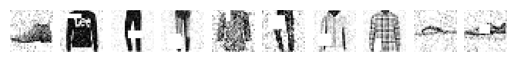

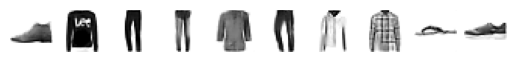

epoch=1, step=1874, loss=0.0056
                                            step=312, loss=0.0049


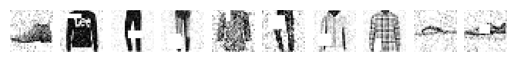

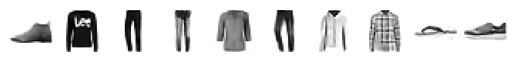

epoch=2, step=1874, loss=0.0050
                                            step=312, loss=0.0048


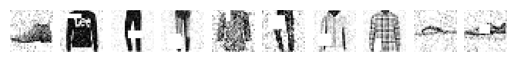

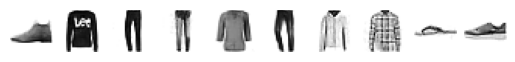

epoch=3, step=1874, loss=0.0048
                                            step=312, loss=0.0061


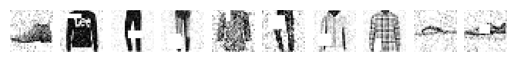

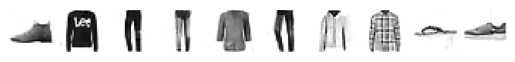

epoch=4, step=1874, loss=0.0046
                                            step=312, loss=0.0045


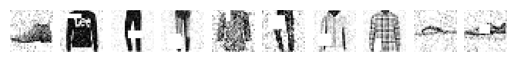

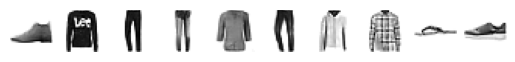

epoch=5, step=1874, loss=0.0044
                                            step=312, loss=0.0042


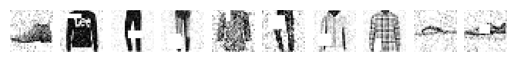

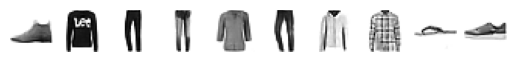

epoch=6, step=1874, loss=0.0043
                                            step=312, loss=0.0042


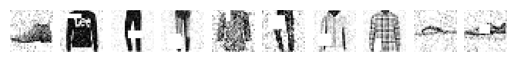

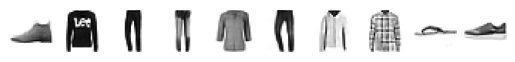

epoch=7, step=1874, loss=0.0041
                                            step=312, loss=0.0042


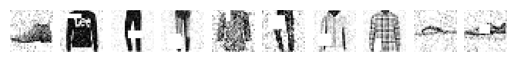

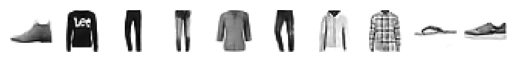

epoch=8, step=1874, loss=0.0041
                                            step=312, loss=0.0041


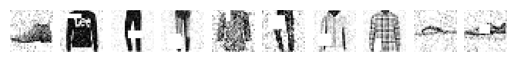

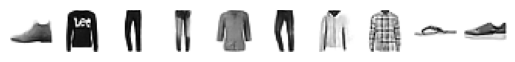

epoch=9, step=1874, loss=0.0040
                                            step=312, loss=0.0041


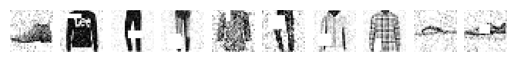

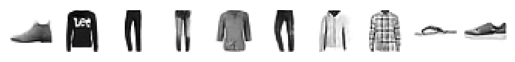

In [10]:
for epoch in range(10):
    model.train()
    loss_list = []
    for step, (x, y) in enumerate(loader_train):
        #1, 2, 3, 4
        x_gpu = x.to(device)
        pred = model(x_gpu)
        loss = loss_fn(pred, y.to(device))
        opt.zero_grad()0
        loss.backward()
        opt.step()

        loss_list.append(loss.item())
        avg_loss = np.mean(loss_list)

        print(f'\repoch={epoch}, step={step}, loss={avg_loss:.4f}', end='')
    print()

    model.eval()
    loss_list = []
    for step, (x, y) in enumerate(loader_valid):
        #1, 2, 3, 4
        x_gpu = x.to(device)
        with torch.no_grad():
            pred = model(x_gpu)
        loss = loss_fn(pred, y.to(device))

        loss_list.append(loss.item())
        avg_loss = np.mean(loss_list)

        print(f'\r {" "*40}   step={step}, loss={avg_loss:.4f}', end='')
    print()
    show_validation()

